In [1]:
# Import necessary libraries
import yfinance as yf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.svm import SVR
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, r2_score

In [2]:
# Step 1: Download historical S&P 500 data using yfinance
ticker = '^GSPC'  # S&P 500 index ticker symbol
data = yf.download(ticker, start='2010-01-01', end='2023-01-01')



[*********************100%***********************]  1 of 1 completed


In [3]:
# Step 2: Feature Engineering
# Calculate daily returns
data['Returns'] = data['Close'].pct_change()

# Calculate log returns
data['Log_Returns'] = np.log(data['Close'] / data['Close'].shift(1))

# Moving Averages
data['MA_5'] = data['Close'].rolling(window=5).mean()
data['MA_20'] = data['Close'].rolling(window=20).mean()

# Volatility (using rolling standard deviation of returns)
data['Volatility'] = data['Returns'].rolling(window=20).std()

# Price Momentum (difference between current price and 10 days ago)
data['Price_Momentum'] = data['Close'] - data['Close'].shift(10)

# Drop rows with NaN values due to rolling calculations
data = data.dropna()

In [4]:
# Step 3: Define features (X) and target (y)
X = data[['Returns', 'Log_Returns', 'MA_5', 'MA_20', 'Volatility', 'Price_Momentum']]
y = data['Close'].values

In [5]:
# Step 4: Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)

In [7]:
# Step 5: Standardize the features using StandardScaler
scaler_X = StandardScaler()
scaler_y = StandardScaler()
X_train_scaled = scaler_X.fit_transform(X_train)
X_test_scaled = scaler_X.transform(X_test)
y_train_scaled = scaler_y.fit_transform(y_train.reshape(-1, 1)).flatten()


In [9]:
# Step 6: Initialize the SVR model and define a parameter grid for hyperparameter tuning
svr = SVR()
param_grid = {
    'C': [0.01, 0.1, 1, 10, 100, 1000],
    'gamma': ['scale', 'auto', 0.001, 0.01],
    'kernel': ['rbf']
}


In [10]:
# Step 7: Set up GridSearchCV to find the best hyperparameters with cross-validation
grid_search = GridSearchCV(svr, param_grid, cv=5, scoring='neg_mean_squared_error', verbose=1)

In [11]:
# Step 8: Train the model using GridSearchCV
grid_search.fit(X_train_scaled, y_train_scaled)

Fitting 5 folds for each of 24 candidates, totalling 120 fits


GridSearchCV(cv=5, estimator=SVR(),
             param_grid={'C': [0.01, 0.1, 1, 10, 100, 1000],
                         'gamma': ['scale', 'auto', 0.001, 0.01],
                         'kernel': ['rbf']},
             scoring='neg_mean_squared_error', verbose=1)

In [12]:
# Get the best parameters found by GridSearchCV
best_params = grid_search.best_params_
print(f"Best Parameters: {best_params}")

Best Parameters: {'C': 100, 'gamma': 0.001, 'kernel': 'rbf'}


In [13]:
# Step 9: Train the SVR model with the best parameters
svr_best = SVR(C=best_params['C'], gamma=best_params['gamma'], kernel=best_params['kernel'])
svr_best.fit(X_train_scaled, y_train_scaled)

SVR(C=100, gamma=0.001)

In [14]:
# Step 10: Make predictions on the test set
y_pred_scaled = svr_best.predict(X_test_scaled)
y_pred = scaler_y.inverse_transform(y_pred_scaled.reshape(-1, 1)).flatten()

In [15]:
# Step 11: Evaluate model performance
mse_test = mean_squared_error(y_test, y_pred)
r2_test = r2_score(y_test, y_pred)
print(f"Test Mean Squared Error: {mse_test}")
print(f"Test R-squared: {r2_test}")

Test Mean Squared Error: 4615.057987253232
Test R-squared: 0.975647173077535


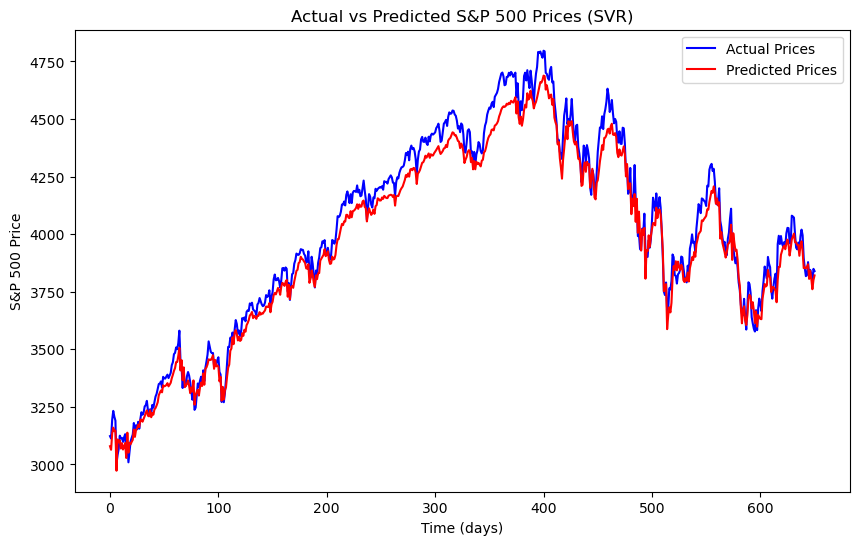

In [16]:
# Step 12: Plot actual vs predicted stock prices
plt.figure(figsize=(10, 6))
plt.plot(y_test, label='Actual Prices', color='blue')
plt.plot(y_pred, label='Predicted Prices', color='red')
plt.title('Actual vs Predicted S&P 500 Prices (SVR)')
plt.xlabel('Time (days)')
plt.ylabel('S&P 500 Price')
plt.legend()
plt.show()

In [17]:
# Step 13: Predict the next day's price using the last row of the test set
last_row = X_test_scaled[-1, :].reshape(1, -1)
next_day_price = svr_best.predict(last_row)
next_day_price = scaler_y.inverse_transform(next_day_price.reshape(-1, 1)).flatten()
print(f"Predicted next day price: {next_day_price[0]}")

Predicted next day price: 3820.6633604574827


In [28]:
# Import necessary libraries
import yfinance as yf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.svm import SVR
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, r2_score

# Step 1: Download historical S&P 500 data using yfinance
ticker = '^GSPC'  # S&P 500 index ticker symbol
data = yf.download(ticker, start='2010-01-01', end='2023-01-01')

# Step 2: Feature Engineering
data['Returns'] = data['Close'].pct_change()
data['Log_Returns'] = np.log(data['Close'] / data['Close'].shift(1))
data['MA_5'] = data['Close'].rolling(window=5).mean()
data['MA_20'] = data['Close'].rolling(window=20).mean()
data['Volatility'] = data['Returns'].rolling(window=20).std()
data['Price_Momentum'] = data['Close'] - data['Close'].shift(10)
data = data.dropna()

# Define features and target
X = data[['Returns', 'Log_Returns', 'MA_5', 'MA_20', 'Volatility', 'Price_Momentum']]
y = data['Close'].values

# Initialize SVR model with best parameters from previous tuning
svr_best = SVR(C=100, gamma=0.001, kernel='rbf')  # Use previously tuned best parameters

# Backtesting parameters
window_size = 252  # Use 252 days (about 1 year) for each training window
test_size = 20     # Use 20 days (about a month) for each test period
n_splits = (len(X) - window_size) // test_size

# Lists to store backtest results
mse_scores = []
r2_scores = []

# Backtesting loop
for i in range(n_splits):
    # Define rolling training and test sets
    start = i * test_size
    end = start + window_size
    X_train = X.iloc[start:end]
    y_train = y[start:end]
    X_test = X.iloc[end:end + test_size]
    y_test = y[end:end + test_size]

    # Scale the data for each split
    scaler_X = StandardScaler()
    scaler_y = StandardScaler()
    X_train_scaled = scaler_X.fit_transform(X_train)
    X_test_scaled = scaler_X.transform(X_test)
    y_train_scaled = scaler_y.fit_transform(y_train.reshape(-1, 1)).flatten()

    # Train SVR model on the rolling window
    svr_best.fit(X_train_scaled, y_train_scaled)

    # Predict on the test set
    y_pred_scaled = svr_best.predict(X_test_scaled)
    y_pred = scaler_y.inverse_transform(y_pred_scaled.reshape(-1, 1)).flatten()

    # Calculate performance metrics
    mse = mean_squared_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)
    mse_scores.append(mse)
    r2_scores.append(r2)

    print(f"Split {i+1}/{n_splits} - MSE: {mse:.2f}, R^2: {r2:.2f}")

# Display average backtesting performance
print(f"\nAverage MSE over backtest: {np.mean(mse_scores):.2f}")
print(f"Average R^2 over backtest: {np.mean(r2_scores):.2f}")


[*********************100%***********************]  1 of 1 completed


Split 1/150 - MSE: 55.49, R^2: 0.60
Split 2/150 - MSE: 56.21, R^2: 0.83
Split 3/150 - MSE: 20.15, R^2: 0.86
Split 4/150 - MSE: 30.98, R^2: 0.84
Split 5/150 - MSE: 42.16, R^2: 0.91
Split 6/150 - MSE: 113.67, R^2: 0.76
Split 7/150 - MSE: 201.60, R^2: 0.96
Split 8/150 - MSE: 447.66, R^2: 0.26
Split 9/150 - MSE: 169.41, R^2: 0.84
Split 10/150 - MSE: 153.72, R^2: 0.66
Split 11/150 - MSE: 214.83, R^2: 0.78
Split 12/150 - MSE: 66.67, R^2: 0.91
Split 13/150 - MSE: 26.94, R^2: 0.91
Split 14/150 - MSE: 29.98, R^2: 0.63
Split 15/150 - MSE: 62.16, R^2: 0.63
Split 16/150 - MSE: 62.17, R^2: 0.67
Split 17/150 - MSE: 65.54, R^2: 0.87
Split 18/150 - MSE: 91.23, R^2: 0.77
Split 19/150 - MSE: 108.23, R^2: 0.56
Split 20/150 - MSE: 10.66, R^2: 0.79
Split 21/150 - MSE: 42.36, R^2: 0.89
Split 22/150 - MSE: 66.25, R^2: 0.77
Split 23/150 - MSE: 89.22, R^2: 0.82
Split 24/150 - MSE: 25.52, R^2: 0.78
Split 25/150 - MSE: 81.09, R^2: 0.85
Split 26/150 - MSE: 14.03, R^2: 0.87
Split 27/150 - MSE: 38.88, R^2: 0.83
Spl

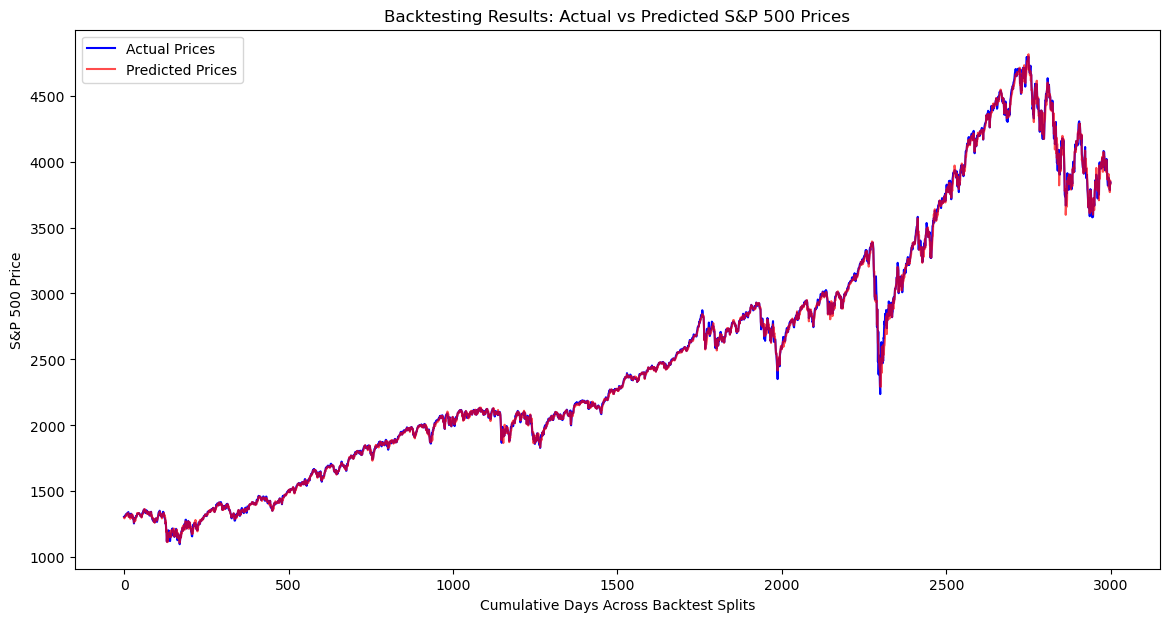

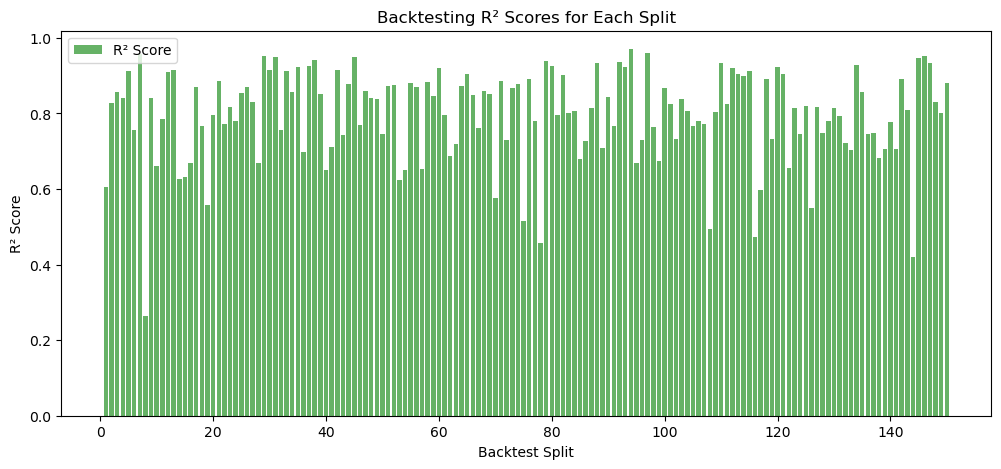

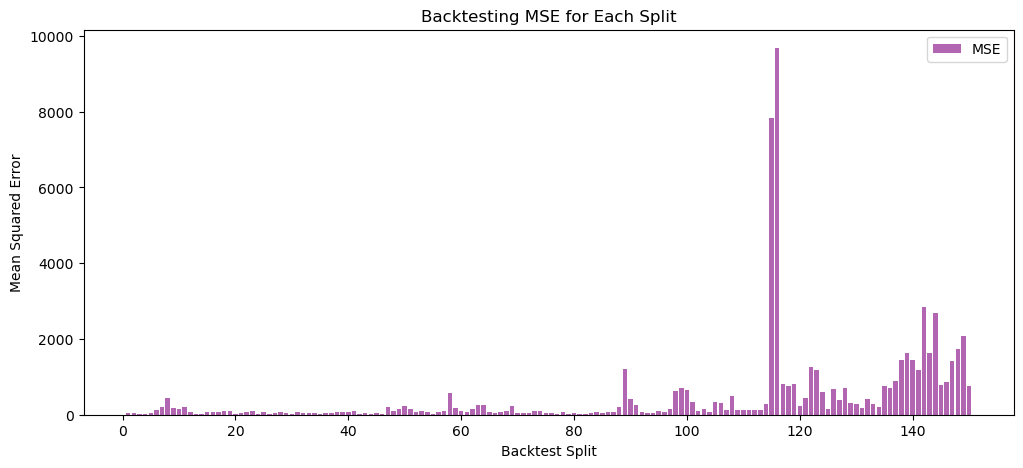

In [29]:
import matplotlib.pyplot as plt

# 1. Line Plot for Actual vs Predicted Prices across all test periods
all_y_test = []
all_y_pred = []

# Backtesting loop (modified to store predictions for cumulative plot)
for i in range(n_splits):
    start = i * test_size
    end = start + window_size
    X_train = X.iloc[start:end]
    y_train = y[start:end]
    X_test = X.iloc[end:end + test_size]
    y_test = y[end:end + test_size]

    # Scale the data
    scaler_X = StandardScaler()
    scaler_y = StandardScaler()
    X_train_scaled = scaler_X.fit_transform(X_train)
    X_test_scaled = scaler_X.transform(X_test)
    y_train_scaled = scaler_y.fit_transform(y_train.reshape(-1, 1)).flatten()

    # Train and predict
    svr_best.fit(X_train_scaled, y_train_scaled)
    y_pred_scaled = svr_best.predict(X_test_scaled)
    y_pred = scaler_y.inverse_transform(y_pred_scaled.reshape(-1, 1)).flatten()
    
    # Store actual and predicted prices
    all_y_test.extend(y_test)
    all_y_pred.extend(y_pred)

# Plot cumulative actual vs predicted prices
plt.figure(figsize=(14, 7))
plt.plot(all_y_test, label="Actual Prices", color="blue")
plt.plot(all_y_pred, label="Predicted Prices", color="red", alpha=0.7)
plt.title("Backtesting Results: Actual vs Predicted S&P 500 Prices")
plt.xlabel("Cumulative Days Across Backtest Splits")
plt.ylabel("S&P 500 Price")
plt.legend()
plt.show()

# 2. Bar Chart for MSE or R² per split
# Create a bar chart to visualize MSE or R² for each backtest split
plt.figure(figsize=(12, 5))
plt.bar(range(1, n_splits + 1), r2_scores, color="green", alpha=0.6, label="R² Score")
plt.title("Backtesting R² Scores for Each Split")
plt.xlabel("Backtest Split")
plt.ylabel("R² Score")
plt.legend()
plt.show()

# Optional: You can also plot the MSE scores
plt.figure(figsize=(12, 5))
plt.bar(range(1, n_splits + 1), mse_scores, color="purple", alpha=0.6, label="MSE")
plt.title("Backtesting MSE for Each Split")
plt.xlabel("Backtest Split")
plt.ylabel("Mean Squared Error")
plt.legend()
plt.show()
